In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader


In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

BES_R_data_files = BES_data_folder + "R_data" + os.sep
if not os.path.exists( BES_R_data_files ):
    os.makedirs( BES_R_data_files )


In [3]:
dataset_name = "W8_only"

In [5]:
%%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

# BES_Panel  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
# print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

FileNotFoundError: [Errno 2] No such file or directory: '../BES_analysis_data/W8_only\\BES2015_W8_v2.3.dta'

In [6]:
BES_Panel["euMIISmall"].value_counts()

Economy                                   3137
Sovereignty/EU bureaucracy                3133
Immigration                               2987
Campaign/outcome fairness                 1002
Cosmopolitanism                            973
No content to reason                       927
Foreign policy                             778
Other                                      768
Protection of rights                       696
EU spending/regulations/cost               438
Other stability or uncertainty concern     328
British/english identity                   315
Social identity/partisanship               309
Family                                     245
EU integration/stability                   145
Name: euMIISmall, dtype: int64

In [8]:
BES_Panel["euRefVote"].value_counts()

Leave the EU             15793
Stay/remain in the EU    15215
Don't know                2018
I would/will not vote      475
Name: euRefVote, dtype: int64

In [9]:
BES_Panel["euMIISmall"][BES_Panel["euRefVote"]=="Leave the EU"].value_counts()

Sovereignty/EU bureaucracy                2895
Immigration                               2657
Campaign/outcome fairness                  499
Economy                                    397
No content to reason                       342
EU spending/regulations/cost               318
Other                                      290
British/english identity                   287
EU integration/stability                    97
Family                                      81
Foreign policy                              77
Social identity/partisanship                71
Protection of rights                        56
Cosmopolitanism                             52
Other stability or uncertainty concern      39
Name: euMIISmall, dtype: int64

In [10]:
BES_Panel["euMIISmall"][BES_Panel["euRefVote"]=="Stay/remain in the EU"].value_counts()

Economy                                   2584
Cosmopolitanism                            911
Foreign policy                             673
Protection of rights                       625
No content to reason                       517
Other                                      410
Campaign/outcome fairness                  383
Other stability or uncertainty concern     272
Immigration                                239
Social identity/partisanship               229
Sovereignty/EU bureaucracy                 185
Family                                     143
EU spending/regulations/cost                97
EU integration/stability                    45
British/english identity                    22
Name: euMIISmall, dtype: int64

In [18]:
SovOrImmLeavers = (BES_Panel["euRefVote"]=="Leave the EU")&((BES_Panel["euMIISmall"] == "Sovereignty/EU bureaucracy") | (BES_Panel["euMIISmall"] == "Immigration"))

Sov = BES_Panel[SovOrImmLeavers]["euMIISmall"] == "Sovereignty/EU bureaucracy"
BES_sov = BES_reduced[SovOrImmLeavers]
BES_sov = BES_sov.drop([x for x in BES_sov.columns if "euRefVote" in x] , axis=1)
BES_sov = BES_sov.drop([x for x in BES_sov.columns if "euMIISmall" in x], axis=1)

In [29]:
Treatment = "TwoLeaverTribes"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [20]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components, display_pca_data, weighted_kde


In [21]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_sov.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_sov.columns,
                             index   = BES_sov.index      )

In [25]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
n_components = 1
# n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = LinearDiscriminantAnalysis() ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std, Sov)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_sov.index)

Wall time: 493 ms


In [30]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

In [35]:
# display_pca_data(n_components, decomp, BES_std)

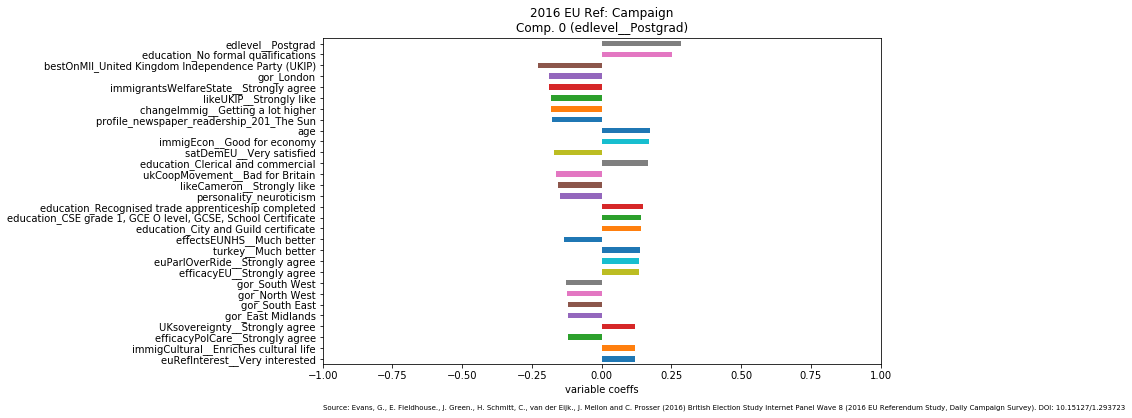

In [33]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_sov.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [34]:
subdir

'../BES_analysis_output/TwoLeaverTribes\\LinearDiscriminantAnalysis'

In [72]:
Sov.value_counts()

0    2895
1    2657
2    2606
dtype: int64

In [ ]:
# try again with all categories?

In [84]:
SovOrImmLeavers = (BES_Panel["euRefVote"]=="Leave the EU") & BES_Panel["euMIISmall"].notnull()
#&((BES_Panel["euMIISmall"] == "Sovereignty/EU bureaucracy") | (BES_Panel["euMIISmall"] == "Immigration"))

Sov_temp = BES_Panel[SovOrImmLeavers]["euMIISmall"]
Sov = Sov_temp.cat.codes.copy()

Sov[Sov_temp == "Sovereignty/EU bureaucracy"] = 0
Sov[Sov_temp == "Immigration"] = 1
Sov[(Sov_temp != "Sovereignty/EU bureaucracy") & (Sov_temp != "Immigration")] = 2

Sov = BES_Panel[SovOrImmLeavers]["euMIISmall"]

#== "Sovereignty/EU bureaucracy"
BES_sov = BES_reduced[SovOrImmLeavers]
BES_sov = BES_sov.drop([x for x in BES_sov.columns if "euRefVote" in x] , axis=1)
BES_sov = BES_sov.drop([x for x in BES_sov.columns if "euMIISmall" in x], axis=1)

In [85]:
Treatment = "AllLeaverTribes"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [86]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_sov.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_sov.columns,
                             index   = BES_sov.index      )

In [90]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
# n_components = BES_std.shape[1]

# n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = LinearDiscriminantAnalysis(n_components=2) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std, Sov)

n_components = X_r.shape[1]

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_sov.index)

Wall time: 900 ms


In [91]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

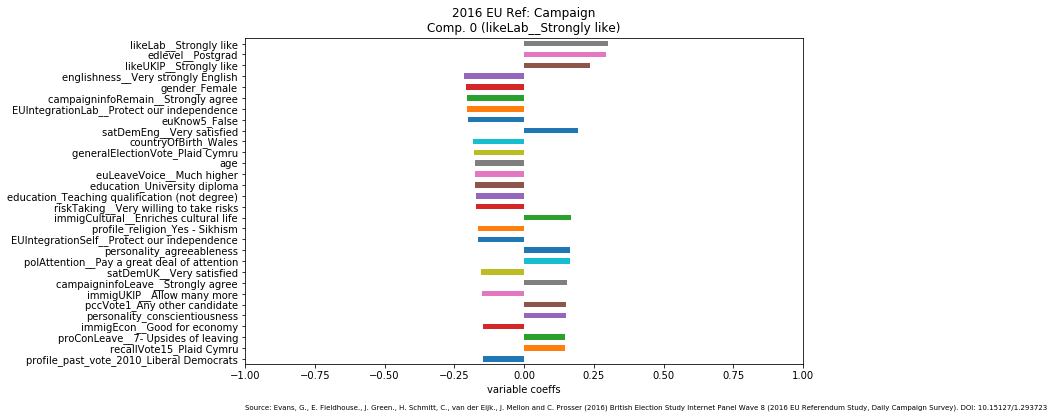

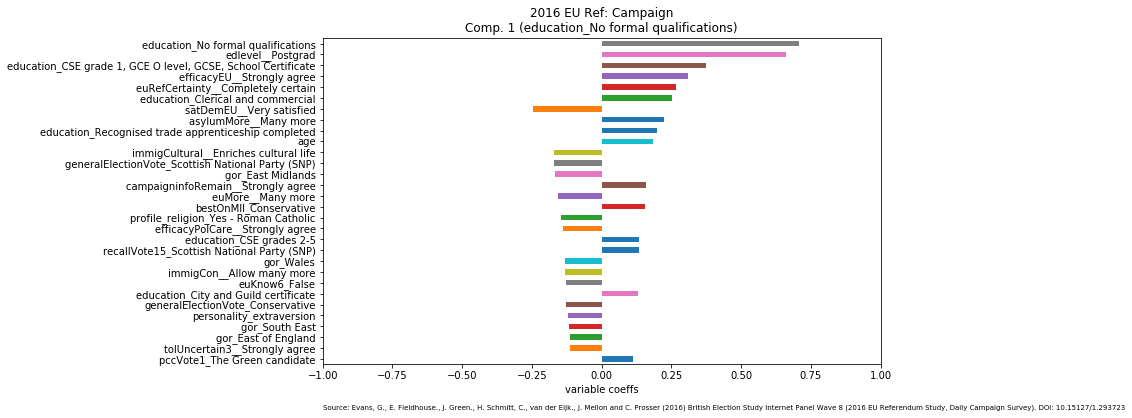

In [92]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_sov.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [102]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

# SparsePCA
if decomp_method == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [100]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

Wall time: 791 ms


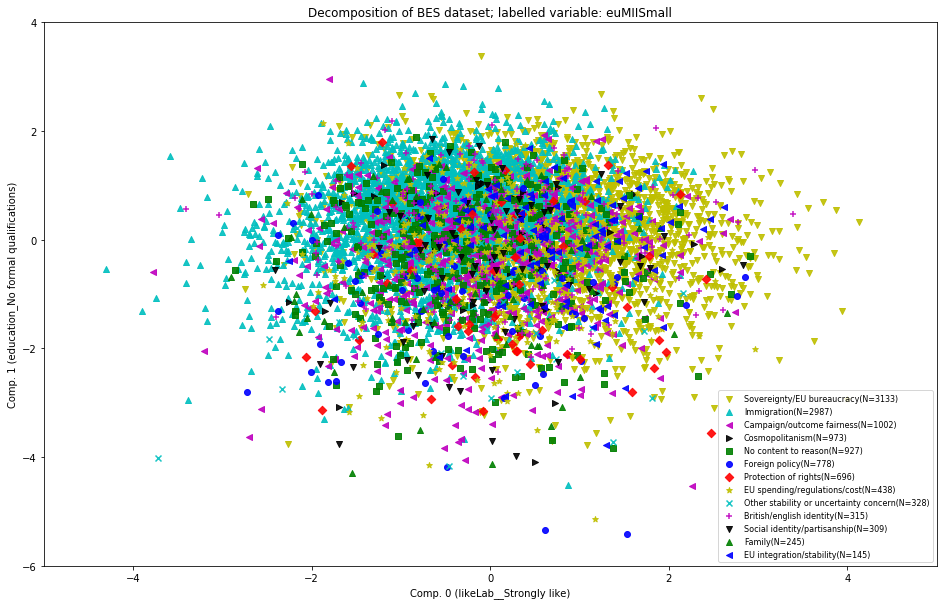

In [104]:
%%time

graph_type = "non_ordinal_scatter/"
folder = output_subfolder +os.sep+ graph_type + os.sep
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = ['euMIISmall']

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced_with_na.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue
        
#     if (decomp_label_col not in BES_reduced.columns):
#         if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
#             decomp_label_categories = new_old_col_names[decomp_label_col]
#         else:
#             continue ## variable removed in transformation
#     else:
#         decomp_label_categories = decomp_label_col        

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced_with_na[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced_with_na[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1